<font size=6>Développer une preuve de concept</font>  
<font size=5>Alternative : améliorer la classification grâce à la détection d'objets</font>  
Comme l'approche testée initialement n'a pas fonctionné, j'ai souhaité tester rapidement une autre voie pour améliorer la prédiction des races de chien. J'applique une détection d'objets pour détecter le chien sur la photo et faire un zoom sur la seule partie de l'image où est le chien. Je n'applique pas de zoom si aucun chien n'est détecté.  
<font size=5>Création et sauvegarde des images croppées</font> sur le chien (ou les chiens) détecté(s) sur chaque photo. Pas de zoom si aucun chien n'est détecté sur la photo.  
Remarque : niveau de confiance de la détection = 50%. Paramètre sous forme de constante qui peut être modifiée.


---

**Vérification de l'environnement**

In [ ]:
import sys
IN_COLAB = "google.colab" in sys.modules
# PATH_DRIVE : to change according to your Google Drive folders
PATH_DRIVE = "/content/drive/My Drive/MachineLearning/ML07"
# IMAGES_DRIVE : to get access to previously loaded images
IMAGES_DRIVE = "/content/drive/My Drive/MachineLearning/ML06/Images"
# CROP_DRIVE : to save to cropped images
CROP_DRIVE = "/content/drive/My Drive/MachineLearning/ML07/CropImages"

In [ ]:
if IN_COLAB:
    print("Le notebook est exécuté sur Google Colab")
else:
    print("Le notebook est exécuté en local")

Le notebook est exécuté sur Google Colab


In [ ]:
if IN_COLAB:
    from google.colab import drive, files
    drive.mount("/content/drive")

Mounted at /content/drive


---

<font size=5>**Sommaire**</font>

[Fonctions de traitement des images](#1_0)  
[Traitement des images](#2_0)  
[Vérification du nombre d'images ajoutées](#3_0)

---
## <font color=blue>Notebook set-up</font>

**Importation des librairies**

In [ ]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import re
import datetime
import random as python_random

In [ ]:
from six import BytesIO
from PIL import Image
from six.moves.urllib.request import urlopen

In [ ]:
if IN_COLAB:
    sys.path.append(PATH_DRIVE)
    os.chdir(PATH_DRIVE)
    import sf_graphiques as sfg
else:
    import modules_perso.sf_graphiques as sfg

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Notebook set-up**

In [ ]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = fig_id + "." + fig_extension
    if IN_COLAB:
        path = PATH_DRIVE + "/" + path
    #print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi=resolution)

In [ ]:
RANDOM_SEED = 42
BATCH_SIZE = 32

In [ ]:
def reset_random_seeds():
    np.random.seed(RANDOM_SEED)
    python_random.seed(RANDOM_SEED)
    tf.random.set_seed(RANDOM_SEED)

In [ ]:
reset_random_seeds()

In [ ]:
tf.get_logger().setLevel('ERROR')

In [ ]:
tf.__version__

'2.4.0'

In [ ]:
tf.keras.__version__

'2.4.0'

In [ ]:
#tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

[]

---
<a id='1_0'></a>

## <font color=blue>Fonctions de traitement des images</font>

Rappel de la méthode de chargement du jeu d'images initial dans ML06.

In [ ]:
#if IN_COLAB:
#    !wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar

In [ ]:
#if IN_COLAB:
#    !tar -xvf images.tar

In [ ]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    image = None
    if(path.startswith('http')):
        response = urlopen(path)
        image_data = response.read()
        image_data = BytesIO(image_data)
        image = Image.open(image_data)
    else:
        image_data = tf.io.gfile.GFile(path, 'rb').read()
        image = Image.open(BytesIO(image_data))

    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (1, im_height, im_width, 3)).astype(np.uint8)

In [ ]:
def get_cropped_imgs(img, detect_threshold, crop_size):
    boxes = []
    detections = hub_model(img)
    for (cl, sc, box) in zip(detections["detection_classes"][0],
                             detections["detection_scores"][0],
                             detections["detection_boxes"][0]):
        if (cl == dog_index) & (sc > detect_threshold):
            boxes.append(box)
    if len(boxes) == 0: # no dog detected -> I keep the full image
        boxes.append([0, 0, 1, 1])
    cropped_images = tf.image.crop_and_resize(
        img, boxes=boxes, box_indices=[0 for i in range(len(boxes))],
        crop_size=crop_size)
    return cropped_images

---
<a id='2_0'></a>

## <font color=blue>Traitement des images</font>

In [ ]:
category_index = pd.read_csv("mscoco_category_index.csv", index_col=0)
dog_index = category_index[category_index.name=="dog"].index[0]

In [ ]:
hub_model = \
   hub.load("https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1")

Je parcours tous les dossiers du dossier principal Images dans lequel sont stockées les images de base.  
Je recrée les mêmes dossiers dans le dossier CROP.  
Pour chaque image:
- j'ouvre l'image,
- je détecte le ou les chiens
- je crée la ou les images zoomées sur le ou les chiens (pas de zoom si aucune détection)
- je sauvegarde dans le bon sous-dossier du dossier CROP.

Création des dossiers CROP

In [ ]:
list_dirs = next(os.walk(IMAGES_DRIVE))[1]
for dir in list_dirs:
    newdir = os.path.join(CROP_DRIVE, dir)
    os.mkdir(newdir)

'\nfor dir in list_dirs:\n    newdir = os.path.join(CROP_DRIVE, dir)\n    os.mkdir(newdir)\n'

Traitement des images

In [ ]:
DETECTION_THRESHOLD = 0.5
CROPSIZE = 256

In [ ]:
for dir in list_dirs:
    race_dir = os.path.join(IMAGES_DRIVE, dir)
    new_dir = os.path.join(CROP_DRIVE, dir)
    list_imgs = next(os.walk(race_dir))[2]
    for filename in list_imgs:
        my_path = os.path.join(race_dir, filename)
        my_img = load_image_into_numpy_array(my_path)
        cropped_imgs = get_cropped_imgs(my_img,
                                        detect_threshold=DETECTION_THRESHOLD,
                                        crop_size=(CROPSIZE, CROPSIZE))
        for idx in range(cropped_imgs.shape[0]):
            new_path = os.path.join(new_dir, "{}_{}".format(idx, filename))
            crop_img = Image.fromarray(
                cropped_imgs[idx, :, :, :].numpy().astype(np.uint8))
            crop_img.save(new_path)
    print("{} Done".format(dir))

n02085620-Chihuahua Done
n02085936-Maltese_dog Done
n02086079-Pekinese Done
n02086240-Shih-Tzu Done
n02088094-Afghan_hound Done
n02088238-basset Done
n02088364-beagle Done
n02088632-bluetick Done
n02089078-black-and-tan_coonhound Done
n02089867-Walker_hound Done
n02090379-redbone Done
n02090622-borzoi Done
n02091032-Italian_greyhound Done
n02091134-whippet Done
n02091467-Norwegian_elkhound Done
n02091831-Saluki Done
n02092339-Weimaraner Done
n02093256-Staffordshire_bullterrier Done
n02093428-American_Staffordshire_terrier Done
n02093647-Bedlington_terrier Done
n02093754-Border_terrier Done
n02093991-Irish_terrier Done
n02094258-Norwich_terrier Done
n02094433-Yorkshire_terrier Done
n02095314-wire-haired_fox_terrier Done
n02095570-Lakeland_terrier Done
n02095889-Sealyham_terrier Done
n02096051-Airedale Done
n02096177-cairn Done
n02096437-Dandie_Dinmont Done
n02096585-Boston_bull Done
n02097047-miniature_schnauzer Done
n02097130-giant_schnauzer Done
n02097298-Scotch_terrier Done
n02097474

ValueError: ignored

In [ ]:
nb_img_race = {}
list_dirs = next(os.walk(CROP_DRIVE))[1]
for dir in list_dirs:
    race_dir = os.path.join(CROP_DRIVE, dir)
    list_imgs = next(os.walk(race_dir))[2]
    nb_img_race[dir] = len(list_imgs)

In [ ]:
np.sum([nb for k, nb in nb_img_race.items()])

22344

In [ ]:
np.sum([1 for k, nb in nb_img_race.items()])

120

Nous disposons désormais de 22 344 photos réparties dans les 120 races. Cela fait 1 764 photos de plus par rapport aux 20 580 photos initiales. Cette augmentation est due à des photos où plusieurs chiens ont été détectés.

In [ ]:
interdata = []
for w in sorted(nb_img_race, key=nb_img_race.get, reverse=True):
    interdata.append([w, nb_img_race[w]])
graph_data = pd.DataFrame(interdata, columns=["race", "nombre_photos"])
graph_data["race"] = graph_data.race.str[10:]
graph_data["race"] = graph_data.race.str.replace("_", " ")
graph_data["race"] = graph_data.race.str.title()
graph_data.head()

,race,nombre_photos
0,Maltese Dog,272
1,Afghan Hound,271
2,Leonberg,253
3,Irish Wolfhound,250
4,Pomeranian,248


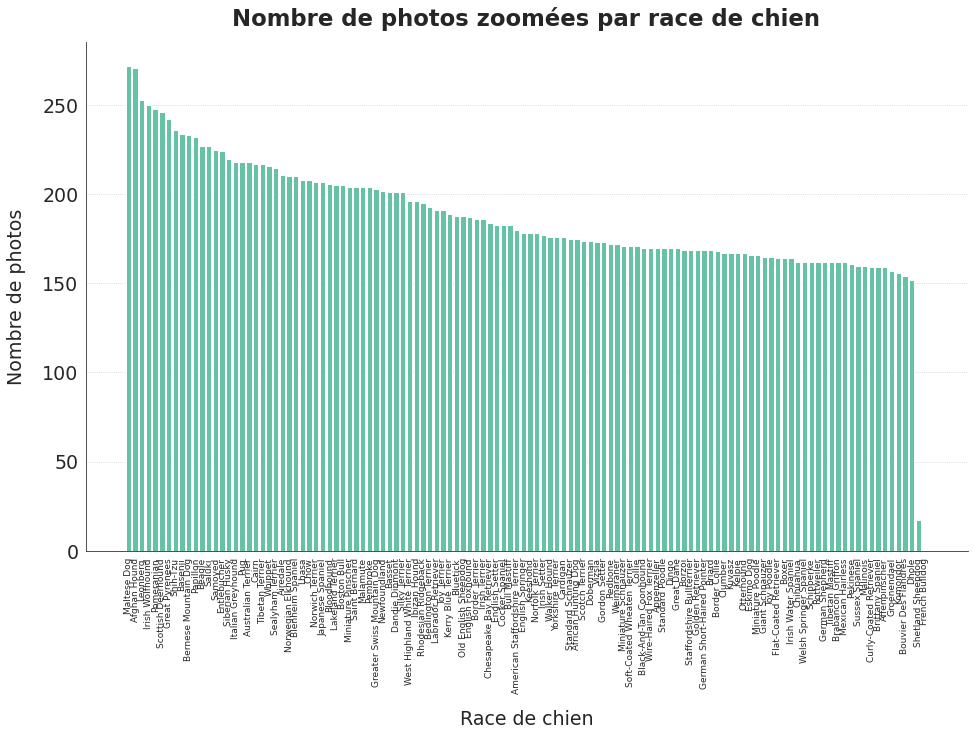

In [ ]:
graph = sfg.MyGraph("Nombre de photos zoomées par race de chien", figsize=(14, 8))
graph.add_barv(graph_data.race, graph_data.nombre_photos)
graph.set_axe_x(label="Race de chien", rotation=90, ha="center")
graph.set_axe_y(label="Nombre de photos", tick_min=0)
fig, ax = graph.fig, graph.ax
ax[0].tick_params(axis="x", labelsize=9)
plt.show()

In [ ]:
nb_img_race_init = {}
list_dirs = next(os.walk(IMAGES_DRIVE))[1]
for dir in list_dirs:
    race_dir = os.path.join(IMAGES_DRIVE, dir)
    list_imgs = next(os.walk(race_dir))[2]
    nb_img_race_init[dir] = len(list_imgs)

In [ ]:
np.sum([nb for k, nb in nb_img_race_init.items()])

20580

In [ ]:
np.sum([1 for k, nb in nb_img_race.items()])

120

In [ ]:
interdata2 = []
for w in sorted(nb_img_race_init, key=nb_img_race_init.get, reverse=True):
    interdata2.append([w, nb_img_race_init[w]])
graph_data2 = pd.DataFrame(interdata2, columns=["race", "nombre_photos"])
graph_data2["race"] = graph_data2.race.str[10:]
graph_data2["race"] = graph_data2.race.str.replace("_", " ")
graph_data2["race"] = graph_data2.race.str.title()
graph_data2.head()

,race,nombre_photos
0,Maltese Dog,252
1,Afghan Hound,239
2,Scottish Deerhound,232
3,Pomeranian,219
4,Bernese Mountain Dog,218


In [ ]:
graph_data2.columns = ["race", "initial_nb"]
graph_data = graph_data.merge(graph_data2, how="left", on="race")
graph_data["nb_new_imgs"] = graph_data.nombre_photos - graph_data.initial_nb
graph_data[graph_data.nb_new_imgs < 0]

,race,nombre_photos,initial_nb,nb_new_imgs
118,Shetland Sheepdog,17,157,-140
119,French Bulldog,0,159,-159


J'ai une erreur lors de l'import des Shetland Sheepdog. Je vérifie l'image originale qui pose problème.

In [ ]:
def debug_load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    image = None
    if(path.startswith('http')):
        response = urlopen(path)
        image_data = response.read()
        image_data = BytesIO(image_data)
        image = Image.open(image_data)
    else:
        image_data = tf.io.gfile.GFile(path, 'rb').read()
        image = Image.open(BytesIO(image_data))

    (im_width, im_height) = image.size
    if (im_width == 213) & (im_height == 189):
        print(path)
    return np.array(image.getdata()).reshape(
        (1, im_height, im_width, 3)).astype(np.uint8)

In [ ]:
dir = "n02105855-Shetland_sheepdog"
race_dir = os.path.join(IMAGES_DRIVE, dir)
list_imgs = next(os.walk(race_dir))[2]
for filename in list_imgs:
    my_path = os.path.join(race_dir, filename)
    my_img = debug_load_image_into_numpy_array(my_path)

/content/drive/My Drive/MachineLearning/ML06/Images/n02105855-Shetland_sheepdog/n02105855_2933.jpg


ValueError: ignored

Il y a une image pour laquelle le nombre de points ne correspond pas à la taille enregistrée en propriétés. Je finis l'extraction des images en ignorant celle qui pose problème : il ne reste plus que les photos de deux races à extraire.

In [ ]:
DETECTION_THRESHOLD = 0.5
CROPSIZE = 256

In [ ]:
for dir in ["n02105855-Shetland_sheepdog", "n02108915-French_bulldog"]:
    race_dir = os.path.join(IMAGES_DRIVE, dir)
    new_dir = os.path.join(CROP_DRIVE, dir)
    list_imgs = next(os.walk(race_dir))[2]
    for filename in list_imgs:
        my_path = os.path.join(race_dir, filename)
        if my_path != "/content/drive/My Drive/MachineLearning/ML06/Images/n02105855-Shetland_sheepdog/n02105855_2933.jpg":
            my_img = load_image_into_numpy_array(my_path)
            cropped_imgs = get_cropped_imgs(my_img,
                                            detect_threshold=DETECTION_THRESHOLD,
                                            crop_size=(CROPSIZE, CROPSIZE))
            for idx in range(cropped_imgs.shape[0]):
                new_path = os.path.join(new_dir, "{}_{}".format(idx, filename))
                crop_img = Image.fromarray(
                    cropped_imgs[idx, :, :, :].numpy().astype(np.uint8))
                crop_img.save(new_path)
    print("{} Done".format(dir))

n02105855-Shetland_sheepdog Done
n02108915-French_bulldog Done


---
<a id='3_0'></a>

## <font color=blue>Vérification du nombre d'images ajoutées</font>

In [ ]:
nb_img_race = {}
list_dirs = next(os.walk(CROP_DRIVE))[1]
for dir in list_dirs:
    race_dir = os.path.join(CROP_DRIVE, dir)
    list_imgs = next(os.walk(race_dir))[2]
    nb_img_race[dir] = len(list_imgs)

In [ ]:
np.sum([nb for k, nb in nb_img_race.items()])

22674

In [ ]:
np.sum([1 for k, nb in nb_img_race.items()])

120

Nous disposons désormais de 22 674 photos réparties dans les 120 races. Cela fait 2 094 photos de plus par rapport aux 20 580 photos initiales. Cette augmentation est due à des photos où plusieurs chiens ont été détectés.

In [ ]:
interdata = []
for w in sorted(nb_img_race, key=nb_img_race.get, reverse=True):
    interdata.append([w, nb_img_race[w]])
graph_data = pd.DataFrame(interdata, columns=["race", "nombre_photos"])
graph_data["race"] = graph_data.race.str[10:]
graph_data["race"] = graph_data.race.str.replace("_", " ")
graph_data["race"] = graph_data.race.str.title()
graph_data.head()

,race,nombre_photos
0,Maltese Dog,272
1,Afghan Hound,271
2,Leonberg,253
3,Irish Wolfhound,250
4,Pomeranian,248


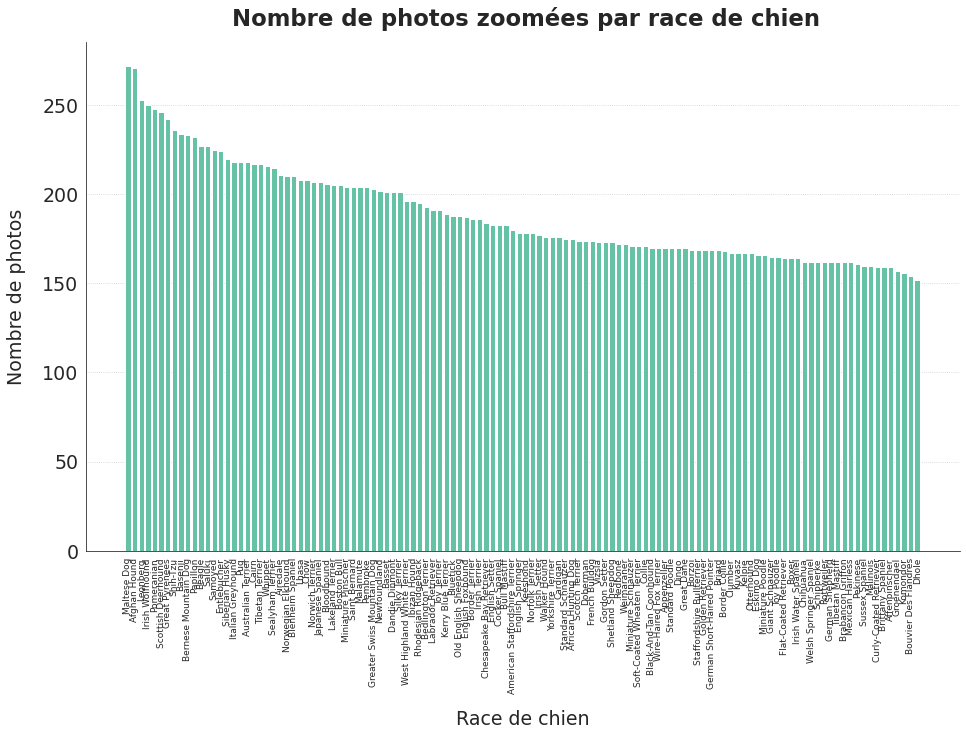

In [ ]:
graph = sfg.MyGraph("Nombre de photos zoomées par race de chien", figsize=(14, 8))
graph.add_barv(graph_data.race, graph_data.nombre_photos)
graph.set_axe_x(label="Race de chien", rotation=90, ha="center")
graph.set_axe_y(label="Nombre de photos", tick_min=0)
fig, ax = graph.fig, graph.ax
ax[0].tick_params(axis="x", labelsize=9)
plt.show()

In [ ]:
nb_img_race_init = {}
list_dirs = next(os.walk(IMAGES_DRIVE))[1]
for dir in list_dirs:
    race_dir = os.path.join(IMAGES_DRIVE, dir)
    list_imgs = next(os.walk(race_dir))[2]
    nb_img_race_init[dir] = len(list_imgs)

In [ ]:
np.sum([nb for k, nb in nb_img_race_init.items()])

20580

In [ ]:
np.sum([1 for k, nb in nb_img_race.items()])

120

In [ ]:
interdata2 = []
for w in sorted(nb_img_race_init, key=nb_img_race_init.get, reverse=True):
    interdata2.append([w, nb_img_race_init[w]])
graph_data2 = pd.DataFrame(interdata2, columns=["race", "nombre_photos"])
graph_data2["race"] = graph_data2.race.str[10:]
graph_data2["race"] = graph_data2.race.str.replace("_", " ")
graph_data2["race"] = graph_data2.race.str.title()
graph_data2.head()

,race,nombre_photos
0,Maltese Dog,252
1,Afghan Hound,239
2,Scottish Deerhound,232
3,Pomeranian,219
4,Bernese Mountain Dog,218


In [ ]:
graph_data2.columns = ["race", "initial_nb"]
graph_data = graph_data.merge(graph_data2, how="left", on="race")
graph_data["nb_new_imgs"] = graph_data.nombre_photos - graph_data.initial_nb

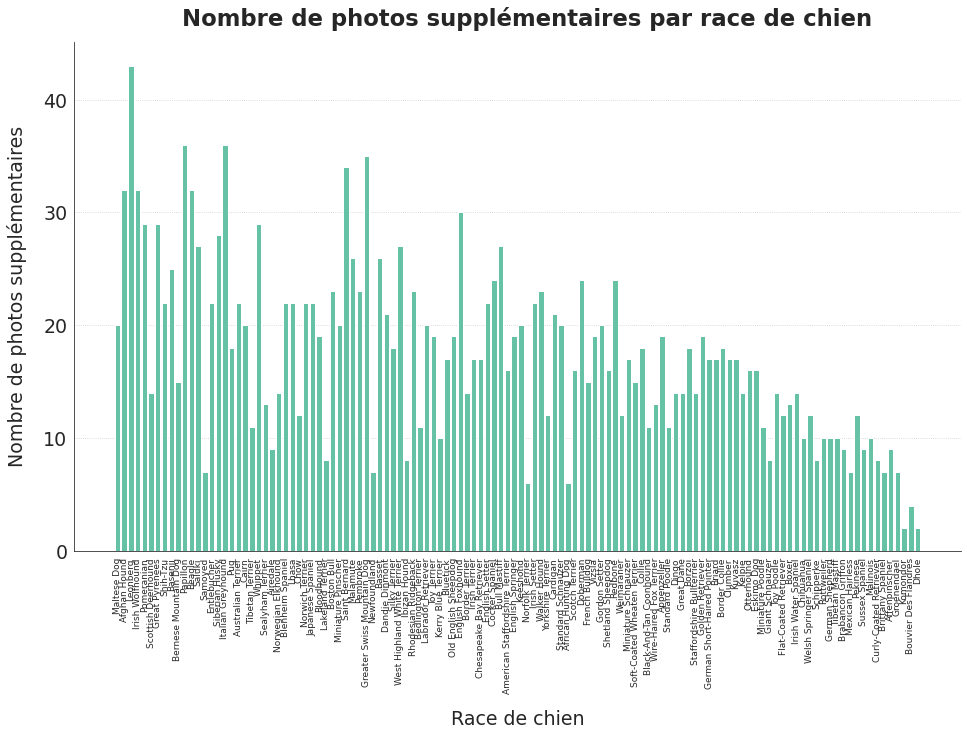

In [ ]:
graph = sfg.MyGraph("Nombre de photos supplémentaires par race de chien", figsize=(14, 8))
graph.add_barv(graph_data.race, graph_data.nb_new_imgs)
graph.set_axe_x(label="Race de chien", rotation=90, ha="center")
graph.set_axe_y(label="Nombre de photos supplémentaires", tick_min=0)
fig, ax = graph.fig, graph.ax
ax[0].tick_params(axis="x", labelsize=9)
plt.show()

Je me rends compte en étudiant rapidement quelques nouvelles photos que celles-ci sont issues de 2 cas différents :
- deux animaux sur la même photo,
- deux rectangles de détection différents sur le même animal.  
  
Les 2 cas sont intéressants et je garde toutes les photos.